In [ ]:
! jt -r

/bin/bash: jt: command not found


In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier

plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def get_class_labels(probs, threshold = 0.8):
    return list(map(lambda x: np.where(x > threshold)[0], probs))

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
                                                
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)

#### Contents
1. Multiclass / multilabel classification
1. SVM + kernels
2. Logreg + meshgrid visualization
3. Confusion matrix & classification report
6. 3d vis

Sklean interface is the same as before:
```
model.fit(X,y)
model.predict(X_test)
model.predict_proba(X_test)
model.score(X, y) #accuracy
```

In [ ]:
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

In [ ]:
iris.feature_names
iris.target_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### 1. Multiclass / multilabel classification

In [ ]:
model = LogisticRegression() #one vs all
model.fit(X, y)
print('======Multiclass prediction:======')
predictions = model.predict(X)#[:15]
predictions

predictions_proba = model.predict_proba(X)
predictions_proba[:15]

# print('======Multilabel prediction:======')
# model = LogisticRegression(multi_class='multinomial') #multinomial logreg
# model.fit(X, y)
# multilabels_preds = model.predict_proba(X)[:10]
# result = pd.DataFrame(multilabels_preds, columns = iris.target_names)
# result['predicted classes'] = get_class_labels(multilabels_preds, 0.1)
# result

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

======Multiclass prediction:======


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

array([[0.92347315, 0.0585081 , 0.01801875],
       [0.791565  , 0.18091265, 0.02752235],
       [0.94236404, 0.05086345, 0.00677251],
       [0.94055354, 0.05375943, 0.00568703],
       [0.96185313, 0.02961439, 0.00853248],
       [0.94319577, 0.03408792, 0.0227163 ],
       [0.98022854, 0.01741711, 0.00235435],
       [0.92292734, 0.06192176, 0.01515091],
       [0.93599898, 0.05999495, 0.00400607],
       [0.84718171, 0.13116503, 0.02165325],
       [0.89021417, 0.07010917, 0.03967666],
       [0.96079337, 0.03317357, 0.00603306],
       [0.84355494, 0.13830534, 0.01813972],
       [0.9679655 , 0.03015099, 0.00188351],
       [0.82409509, 0.07618374, 0.09972117]])

#### Multilabel

In [ ]:
def plot_subfigure(X, Y, title, clf):

    X = PCA(n_components=2).fit_transform(X)

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

#     plt.subplot(2, 2, subplot)
#     plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')

#     plot_hyperplane(clf.estimators_[0], min_x, max_x, 'k--',
#                     'Boundary\nfor class 1')
#     plot_hyperplane(clf.estimators_[1], min_x, max_x, 'k-.',
#                     'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper left")
    plt.title(title)

((200, 10), (200, 2))

array([[0, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [1, 0]])

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

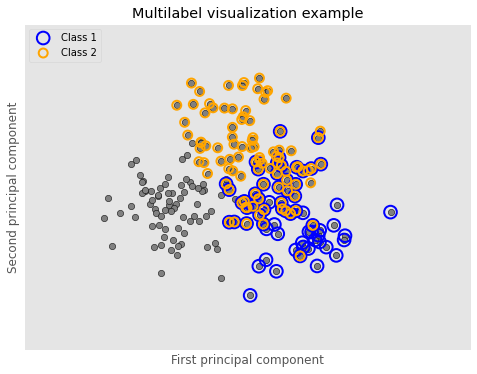

In [ ]:
X, Y = make_multilabel_classification(n_samples = 200,
                                      n_features = 10,
                                      n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)
X.shape, Y.shape

Y[:10]

classif = OneVsRestClassifier(LogisticRegression())
classif.fit(X, Y)

plot_subfigure(X, Y, "Multilabel visualization example", classif)

### 1. SVM with different kernels + decision boundary visualization

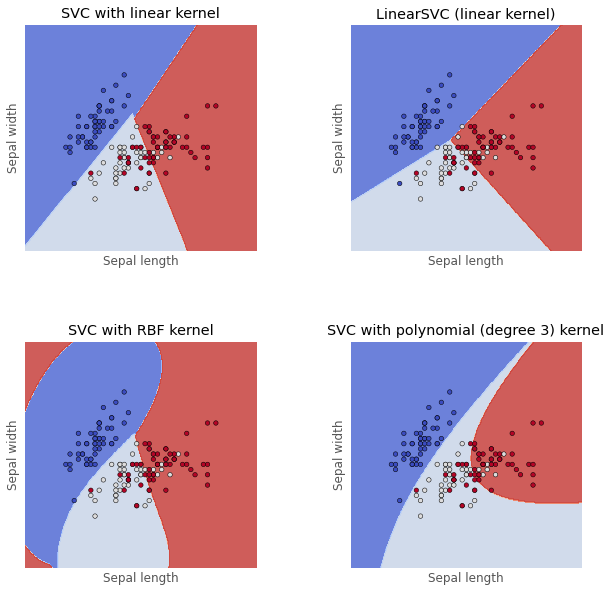

In [ ]:
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = [svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)]
models = [clf.fit(X, y) for clf in models]

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

fig, sub = plt.subplots(2, 2);
plt.subplots_adjust(wspace=0.4, hspace=0.4);

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8);
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');
    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    ax.set_xlabel('Sepal length');
    ax.set_ylabel('Sepal width');
    ax.set_xticks(());
    ax.set_yticks(());
    ax.set_title(title);
    
plt.show();

### 2. Logreg + probability visualization

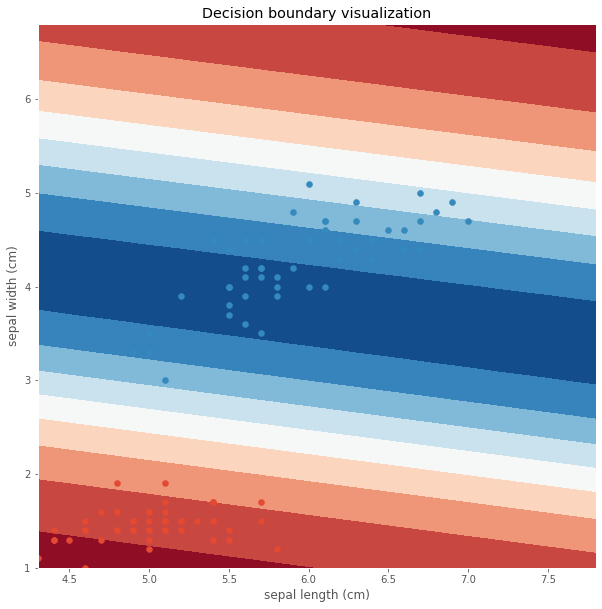

In [ ]:
iris = datasets.load_iris()
X = iris.data[:,[0,2]]
y = iris.target

# define bounds of the domain
min1, max1 = X[:, 0].min(), X[:, 0].max()
min2, max2 = X[:, 1].min(), X[:, 1].max()
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
model = LogisticRegression(C=0.1)
# fit the model
model.fit(X, y)
# make predictions for the grid
yhat = model.predict_proba(grid)
yhat = yhat[:, 1]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='RdBu');
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='RdBu');
# show the plot
plt.xlabel('sepal length (cm)');
plt.ylabel('sepal width (cm)');
plt.title('Decision boundary visualization');
plt.show();

### 3. Classification reports

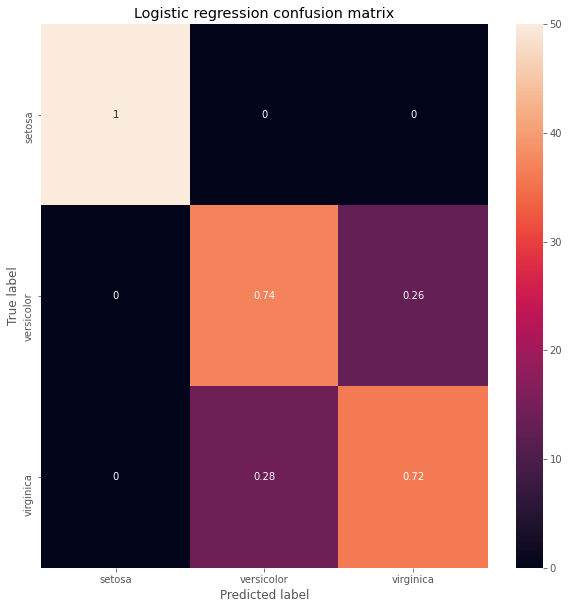

In [ ]:
conf = confusion_matrix(y, predictions)
sns.heatmap(conf,
            annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
            yticklabels=iris.target_names,
            xticklabels=iris.target_names);
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [ ]:
# https://muthu.co/understanding-the-classification-report-in-sklearn/
print(classification_report(y, predictions, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.73      0.74      0.73        50
   virginica       0.73      0.72      0.73        50

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



### 3D visualization

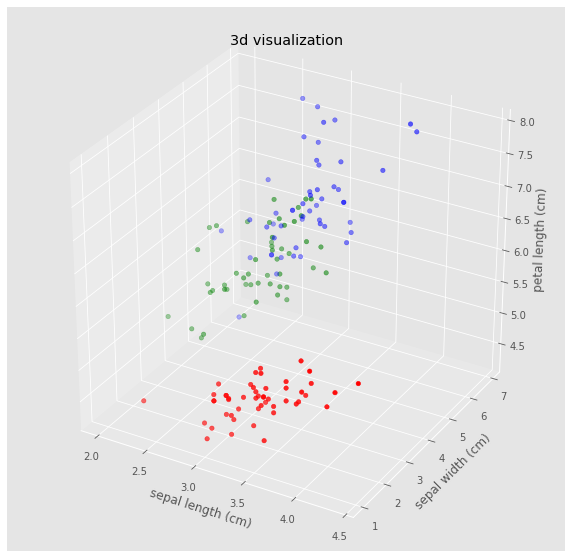

In [ ]:
X = iris.data
y = iris.target
colors = ['red','green','blue']
c = list(map(lambda x: colors[x], y))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,1], X[:,2], X[:,0], c=c);
ax.set_title('3d visualization');
ax.set_xlabel(iris.feature_names[0]);
ax.set_ylabel(iris.feature_names[1]);
ax.set_zlabel(iris.feature_names[2]);

In [ ]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
df = pd.DataFrame(X, columns=iris.feature_names)
fig = px.scatter_3d(df,
                    x='sepal length (cm)',z='sepal width (cm)',y='petal length (cm)', 
                    color=y)
fig.show()